In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import copy
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import shutil
import random

# root directory containing dataset
dataset_root = "/content/gdrive/My Drive/cervical"

# subfolders (classes) in the dataset
subfolders = ["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]


train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "val")
test_dir = os.path.join(dataset_root, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_root, subfolder)
    class_images = os.listdir(subfolder_path)
    random.shuffle(class_images)

    num_images = len(class_images)
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)

    # Creating subfolders inside train, validation, and test directories
    train_class_dir = os.path.join(train_dir, subfolder)
    val_class_dir = os.path.join(val_dir, subfolder)
    test_class_dir = os.path.join(test_dir, subfolder)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Splitting the images into train, validation, and test sets
    train_images = class_images[:num_train]
    val_images = class_images[num_train:num_train + num_val]
    test_images = class_images[num_train + num_val:]

    # Copying images to their respective subfolders
    for img in train_images:
        shutil.copy(os.path.join(subfolder_path, img), os.path.join(train_class_dir, img))
    for img in val_images:
        shutil.copy(os.path.join(subfolder_path, img), os.path.join(val_class_dir, img))
    for img in test_images:
        shutil.copy(os.path.join(subfolder_path, img), os.path.join(test_class_dir, img))


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.preprocessing import LabelEncoder, OneHotEncoder




input_shape = (224, 224, 3)
num_classes = 5


batch_size = 32
num_epochs = 10

# Loading and preprocessing the dataset
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=50,
    zoom_range=[0.5, 1.0]
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    interpolation='bilinear',
    classes=["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    interpolation='bilinear',
    classes=["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
)

# DenseNet121 base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Adding custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

#  final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreezing the last few layers for fine-tuning
for layer in base_model.layers[:-100]:
    layer.trainable = False

# model compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# checkpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[early_stopping, checkpoint]
)


Found 8175 images belonging to 5 classes.
Found 1749 images belonging to 5 classes.
29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/10
255/255 [==============================] - ETA: 0s - loss: 1.2497 - accuracy: 0.7674 - precision: 0.8221 - recall: 0.7027

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


255/255 [==============================] - 446s 2s/step - loss: 1.2497 - accuracy: 0.7674 - precision: 0.8221 - recall: 0.7027 - val_loss: 0.4696 - val_accuracy: 0.8773 - val_precision: 0.8834 - val_recall: 0.8721
Epoch 2/10
255/255 [==============================] - 404s 2s/step - loss: 0.4241 - accuracy: 0.8579 - precision: 0.8950 - recall: 0.8184 - val_loss: 0.4165 - val_accuracy: 0.8906 - val_precision: 0.9038 - val_recall: 0.8808
Epoch 3/10
255/255 [==============================] - 427s 2s/step - loss: 0.3785 - accuracy: 0.8724 - precision: 0.9106 - recall: 0.8368 - val_loss: 0.3479 - val_accuracy: 0.8900 - val_precision: 0.9050 - val_recall: 0.8819
Epoch 4/10
255/255 [==============================] - 430s 2s/step - loss: 0.3707 - accuracy: 0.8769 - precision: 0.9102 - recall: 0.8416 - val_loss: 0.2066 - val_accuracy: 0.9334 - val_precision: 0.9467 - val_recall: 0.9259
Epoch 5/10
255/255 [==============================] - 423s 2s/step - loss: 0.3026 - accuracy: 0.8966 - precisio

In [ ]:


test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    interpolation='bilinear',
    classes= ["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
)

# Evaluating the model on the test set
test_results = model.evaluate(test_generator)

print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


Found 1757 images belonging to 5 classes.
55/55 [==============================] - 62s 1s/step - loss: 6.2438 - accuracy: 0.9061 - precision: 0.9123 - recall: 0.8998
Test Loss: 6.243751525878906
Test Accuracy: 0.9060899019241333


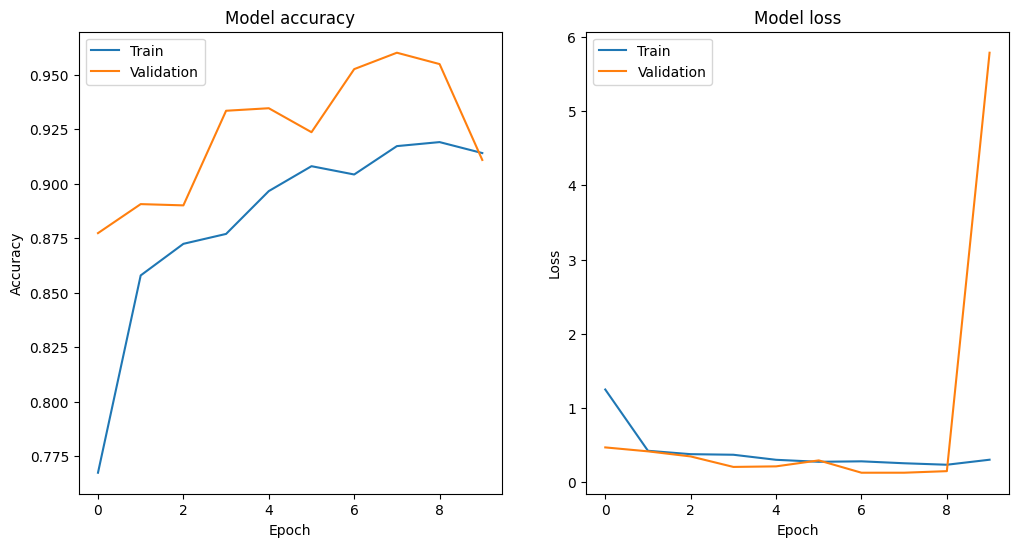

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


55/55 [==============================] - 55s 997ms/step


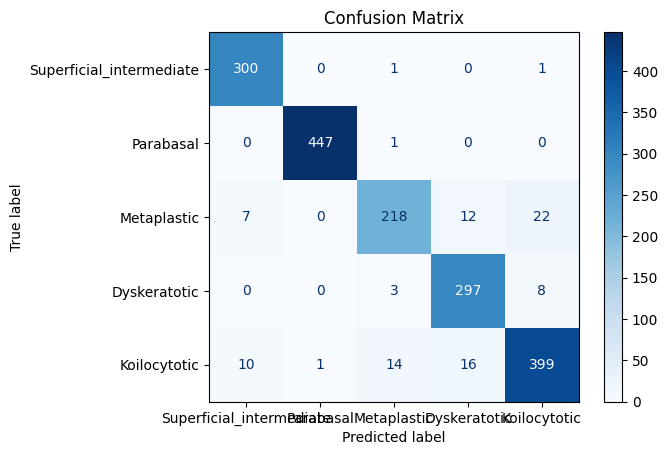

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model.load_weights('best_model.h5')


true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
display = ConfusionMatrixDisplay(confusion, display_labels=class_names)
display.plot(cmap=plt.cm.Blues, values_format='d')

plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report


true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

class_names = ["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)


55/55 [==============================] - 57s 1s/step
                          precision    recall  f1-score   support

Superficial_intermediate       0.95      0.99      0.97       302
               Parabasal       1.00      1.00      1.00       448
             Metaplastic       0.92      0.84      0.88       259
            Dyskeratotic       0.91      0.96      0.94       308
            Koilocytotic       0.93      0.91      0.92       440

                accuracy                           0.95      1757
               macro avg       0.94      0.94      0.94      1757
            weighted avg       0.95      0.95      0.94      1757



In [ ]:
loaded_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def predict_image(path):
    global loaded_model


    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    input_arr = np.array([img_array])
    input_arr.shape


    predictions = loaded_model.predict(input_arr)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]


    class_labels = ["Superficial_intermediate", "Parabasal", "Metaplastic", "Dyskeratotic", "Koilocytotic"]

    predicted_class_label = class_labels[predicted_class_index]

    # Display image
    plt.imshow(input_arr[0], vmin=0, vmax=1)
    plt.title(f"Predicted Class: {predicted_class_label}")
    plt.show()

1/1 [==============================] - 0s 26ms/step


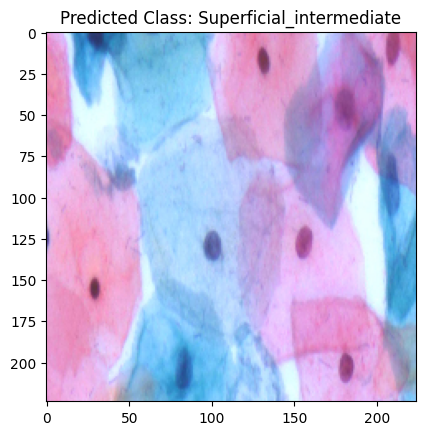

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/1.jpg'
predict_image(image_path)

1/1 [==============================] - 0s 25ms/step


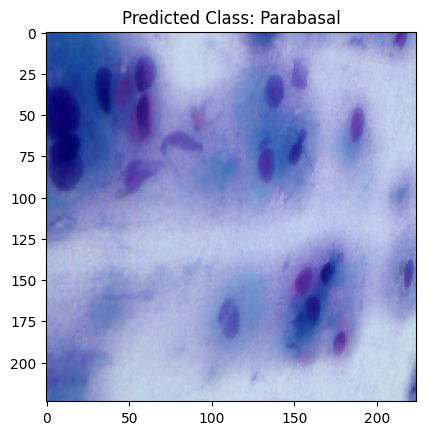

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/2.jpg'
predict_image(image_path)

1/1 [==============================] - 0s 26ms/step


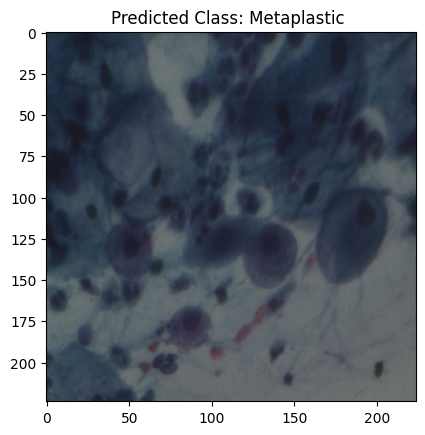

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/3.jpg'
predict_image(image_path)

1/1 [==============================] - 0s 28ms/step


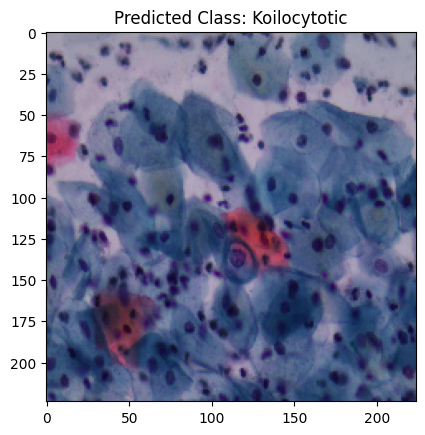

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/4.jpg'
predict_image(image_path)

1/1 [==============================] - 0s 26ms/step


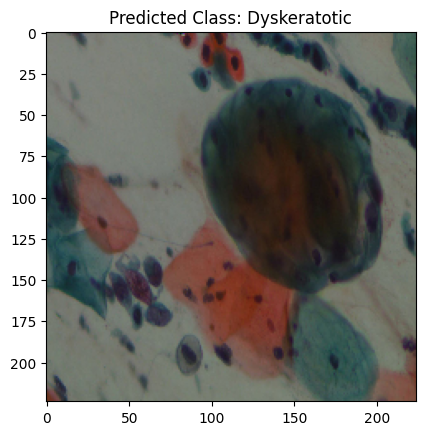

In [ ]:
image_path='/content/gdrive/My Drive/cervical/prediction/5.jpg'
predict_image(image_path)